In [6]:
import trimesh
import numpy as np
from scipy import integrate, optimize
import math

In [7]:
trimesh.load("/Users/jeffreyliang/Documents/Honours/Blender/oblique/exports/Oblique1T.obj").volume

4.397630983694728

In [3]:
def R(x, s, C):
    return s * np.sqrt(1.2**2 - x**2) * (0.1*x + C)

def A_slice(x, s, u, C):
    d = 2*x + u
    R0 = R(x, s, C)
    if d >= R0:
        return 0.0  # Entire disk is below the plane → remove all
    elif d <= -R0:
        return np.pi * R0**2  # Entire disk is above the plane → keep all
    else:
        return R0**2 * np.arccos(d / R0) - d * np.sqrt(R0**2 - d**2)

def V_total(s, u, C):
    f = lambda x: A_slice(x, s, u, C)
    return integrate.quad(f, -1.2, 1.2)[0]

def find_s(u, C):
    # target volume = 1.4*pi
    target = 1.4*np.pi
    root = optimize.brentq(lambda s: V_total(s, u, C) - target,
                          a=1e-3, b=1e3)
    return root

C = np.sqrt(544283/10)/300
V_total(1, -3, C)
find_s(-1, C)

1.167870516925169

In [5]:
V_total(1, -1, C)

3.2467044950125805

In [4]:
find_s(-1, C)

1.167870516925169

In [7]:
find_s(-2, C)

1.024821538398861

In [8]:
find_s(-1.5, C)

1.0794698191816499

In [5]:
find_s(0, C)

1.4803106027848818

In [11]:
[round(u, 2) for u in np.arange(-2.7, -0.7 + 0.01, 0.2)]


[-2.7, -2.5, -2.3, -2.1, -1.9, -1.7, -1.5, -1.3, -1.1, -0.9, -0.7]

In [9]:
# Parameters (match Desmos)
d = 2.8
f = 24
t = 0.5

# Derived values
v = d / t - 4.9 * t
print(f"Initial velocity v = {v:.2f}")

# Function definition for g(x)
def g(x, d, f, t):
    linear = (d / f - 4.9 * t**2 / f) * x
    quad = 4.9 * (x * t / f)**2
    return linear + quad

# Discrete steps from x = 0 to f
X = np.arange(0, f + 1)
g_X = g(X, d, f, t)

# Compute transformed u values
u_values = (d - g_X) * np.sqrt(5)
-u_values.round(2)

Initial velocity v = 3.15


array([-6.26, -6.11, -5.95, -5.78, -5.6 , -5.41, -5.21, -5.  , -4.78,
       -4.56, -4.32, -4.07, -3.82, -3.55, -3.27, -2.99, -2.7 , -2.39,
       -2.08, -1.76, -1.42, -1.08, -0.73, -0.37, -0.  ])

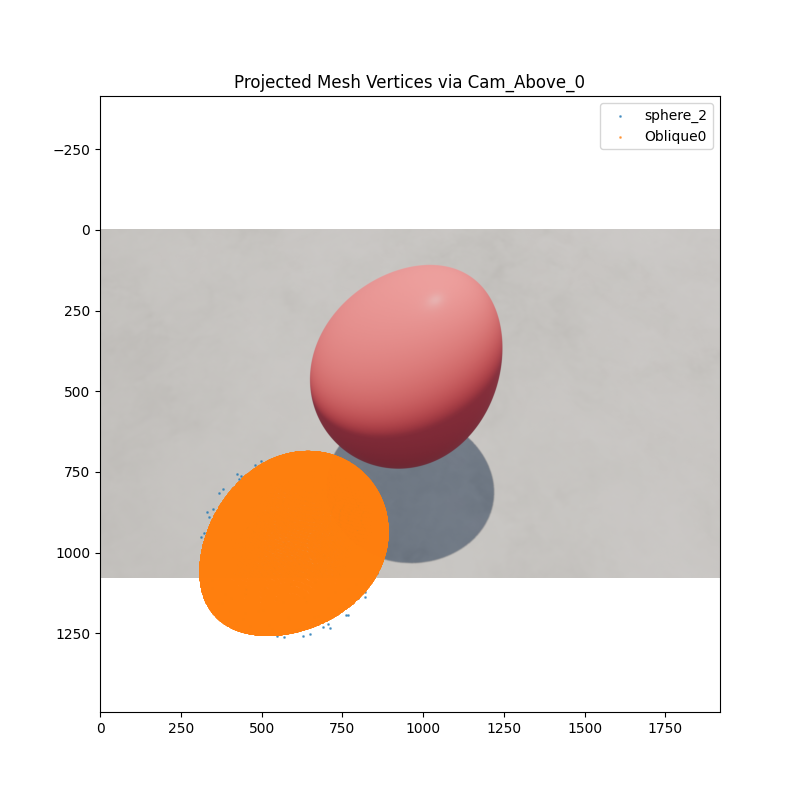

In [45]:
import numpy as np
import torch
from pytorch3d.io import load_obj
import matplotlib.pyplot as plt

# --- Paths ---
sphere_path = "/Users/jeffreyliang/Documents/Honours/Blender/oblique/exports/sphere_2.obj"
oblique_path = "/Users/jeffreyliang/Documents/Honours/Blender/oblique/exports/Oblique0.obj"
projmat_path = "/Users/jeffreyliang/Documents/Honours/Blender/oblique/cameras/Cam_Above_0_P.npy"

# --- Load Mesh Vertices ---
def load_vertices(obj_path):
    verts, faces, _ = load_obj(obj_path)
    return verts  # (N, 3)
def reorient_from_blender_to_matplotlib(verts):
    # Blender: X (right), Y (forward), Z (up)
    # Matplotlib (and most projections): X (right), Y (up), Z (forward)
    return torch.stack([verts[:, 0], -verts[:, 2], verts[:, 1]], dim=1)

sphere_verts = load_vertices(sphere_path)
oblique_verts = load_vertices(oblique_path)
# sphere_verts = reorient_from_blender_to_matplotlib(sphere_verts)
# oblique_verts = reorient_from_blender_to_matplotlib(oblique_verts)

# --- Load Projection Matrix ---
P = torch.tensor(np.load(projmat_path))  # shape: (3, 4)

# --- Project Vertices ---
def project_points(verts, P):
    ones = torch.ones((verts.shape[0], 1), device=verts.device)
    verts_homo = torch.cat([verts, ones], dim=1).double()  # (N, 4)
    proj = (P @ verts_homo.T).T  # (N, 3)
    return proj[:, :2] / proj[:, 2:]  # divide x, y by z

proj_sphere = project_points(sphere_verts, P)
proj_oblique = project_points(oblique_verts, P)

image_width = 1920
image_height = 1080
def rotate_2d_points_180(points_2d, image_width, image_height):
    cx, cy = image_width / 2, image_height / 2
    return 2 * torch.tensor([cx, cy]) - points_2d

proj_sphere_rot = rotate_2d_points_180(proj_sphere, image_width, image_height)
proj_oblique_rot = rotate_2d_points_180(proj_oblique, image_width, image_height)


# --- Plot ---
plt.figure(figsize=(8, 8))
plt.scatter(proj_sphere[:, 0], proj_sphere[:, 1], s=1, label="sphere_2", alpha=0.6)
plt.scatter(proj_oblique[:, 0], proj_oblique[:, 1], s=1, label="Oblique0", alpha=0.6)
plt.legend()
plt.axis("equal")
plt.title("Projected Mesh Vertices via Cam_Above_0")
plt.gca().invert_yaxis()

img = plt.imread("/Users/jeffreyliang/Documents/Honours/Blender/oblique/renders/Diffuse/Oblique0_Cam_Above_0.png")
plt.imshow(img)
plt.show()


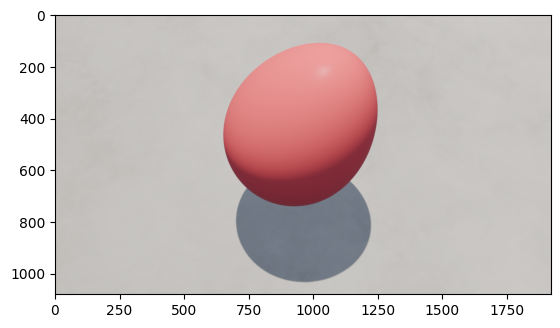

In [11]:
img = plt.imread("/Users/jeffreyliang/Documents/Honours/Blender/oblique/renders/Diffuse/Oblique0_Cam_Above_0.png")
plt.imshow(img)
plt.show()


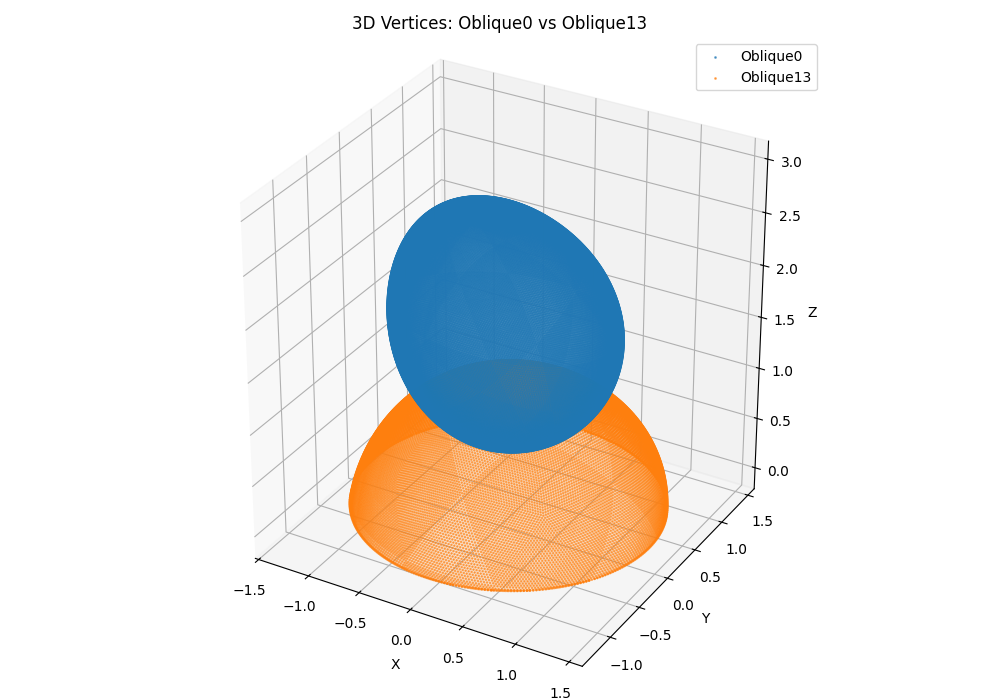

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib ipympl

# Load the two OBJ files (only vertices, assuming standard OBJ format with 'v' lines)
def load_vertices_from_obj(path):
    with open(path, 'r') as f:
        lines = f.readlines()
    verts = [list(map(float, line.strip().split()[1:4]))
             for line in lines if line.startswith('v ')]
    return np.array(verts)

# Paths to the OBJ files
path0 = "/Users/jeffreyliang/Documents/Honours/Blender/oblique/exports/Oblique0.obj"
path13 = "/Users/jeffreyliang/Documents/Honours/Blender/oblique/exports/Oblique13.obj"

# Load vertices
verts0 = load_vertices_from_obj(path0)
verts13 = load_vertices_from_obj(path13)
def reorient_for_matplotlib(verts):
    # Convert Blender's (X, Y, Z) → Matplotlib's (X, Z, -Y)
    return np.stack([verts[:, 0], -verts[:, 2], verts[:, 1]], axis=1)

# Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
verts0_plot = reorient_for_matplotlib(verts0)
verts13_plot = reorient_for_matplotlib(verts13)

ax.scatter(verts0_plot[:, 0], verts0_plot[:, 1], verts0_plot[:, 2], s=1, label="Oblique0", alpha=0.6)
ax.scatter(verts13_plot[:, 0], verts13_plot[:, 1], verts13_plot[:, 2], s=1, label="Oblique13", alpha=0.6)

# ax.scatter(verts0[:, 0], verts0[:, 1], verts0[:, 2], s=1, label="Oblique0", alpha=0.6)
# ax.scatter(verts13[:, 0], verts13[:, 1], verts13[:, 2], s=1, label="Oblique13", alpha=0.6)

ax.set_title("3D Vertices: Oblique0 vs Oblique13")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
# ax.view_init(elev=20, azim=45)
ax.set_aspect("equal")
plt.tight_layout()
plt.show()


In [3]:
from pathlib import Path
import trimesh
import math

base_dir = Path("/Users/jeffreyliang/Documents/Honours/Blender/oblique/exports/")
tot = 0
objects = [f"Sphere0_{i}" for i in range(2,4)]

for obj_name in objects:
    mesh_path = base_dir / f"{obj_name}.obj"
    mesh = trimesh.load(mesh_path, process=True)
    volume = mesh.volume
    print(f"{obj_name}: Volume = {volume:.10f}  Volume = {(1.4 * math.pi - volume):.10f}")
    tot += volume

print(tot / len(objects))


Sphere0_2: Volume = 4.3982299717  Volume = -0.0000002566
Sphere0_3: Volume = 4.3982299341  Volume = -0.0000002191
4.3982299528872915
